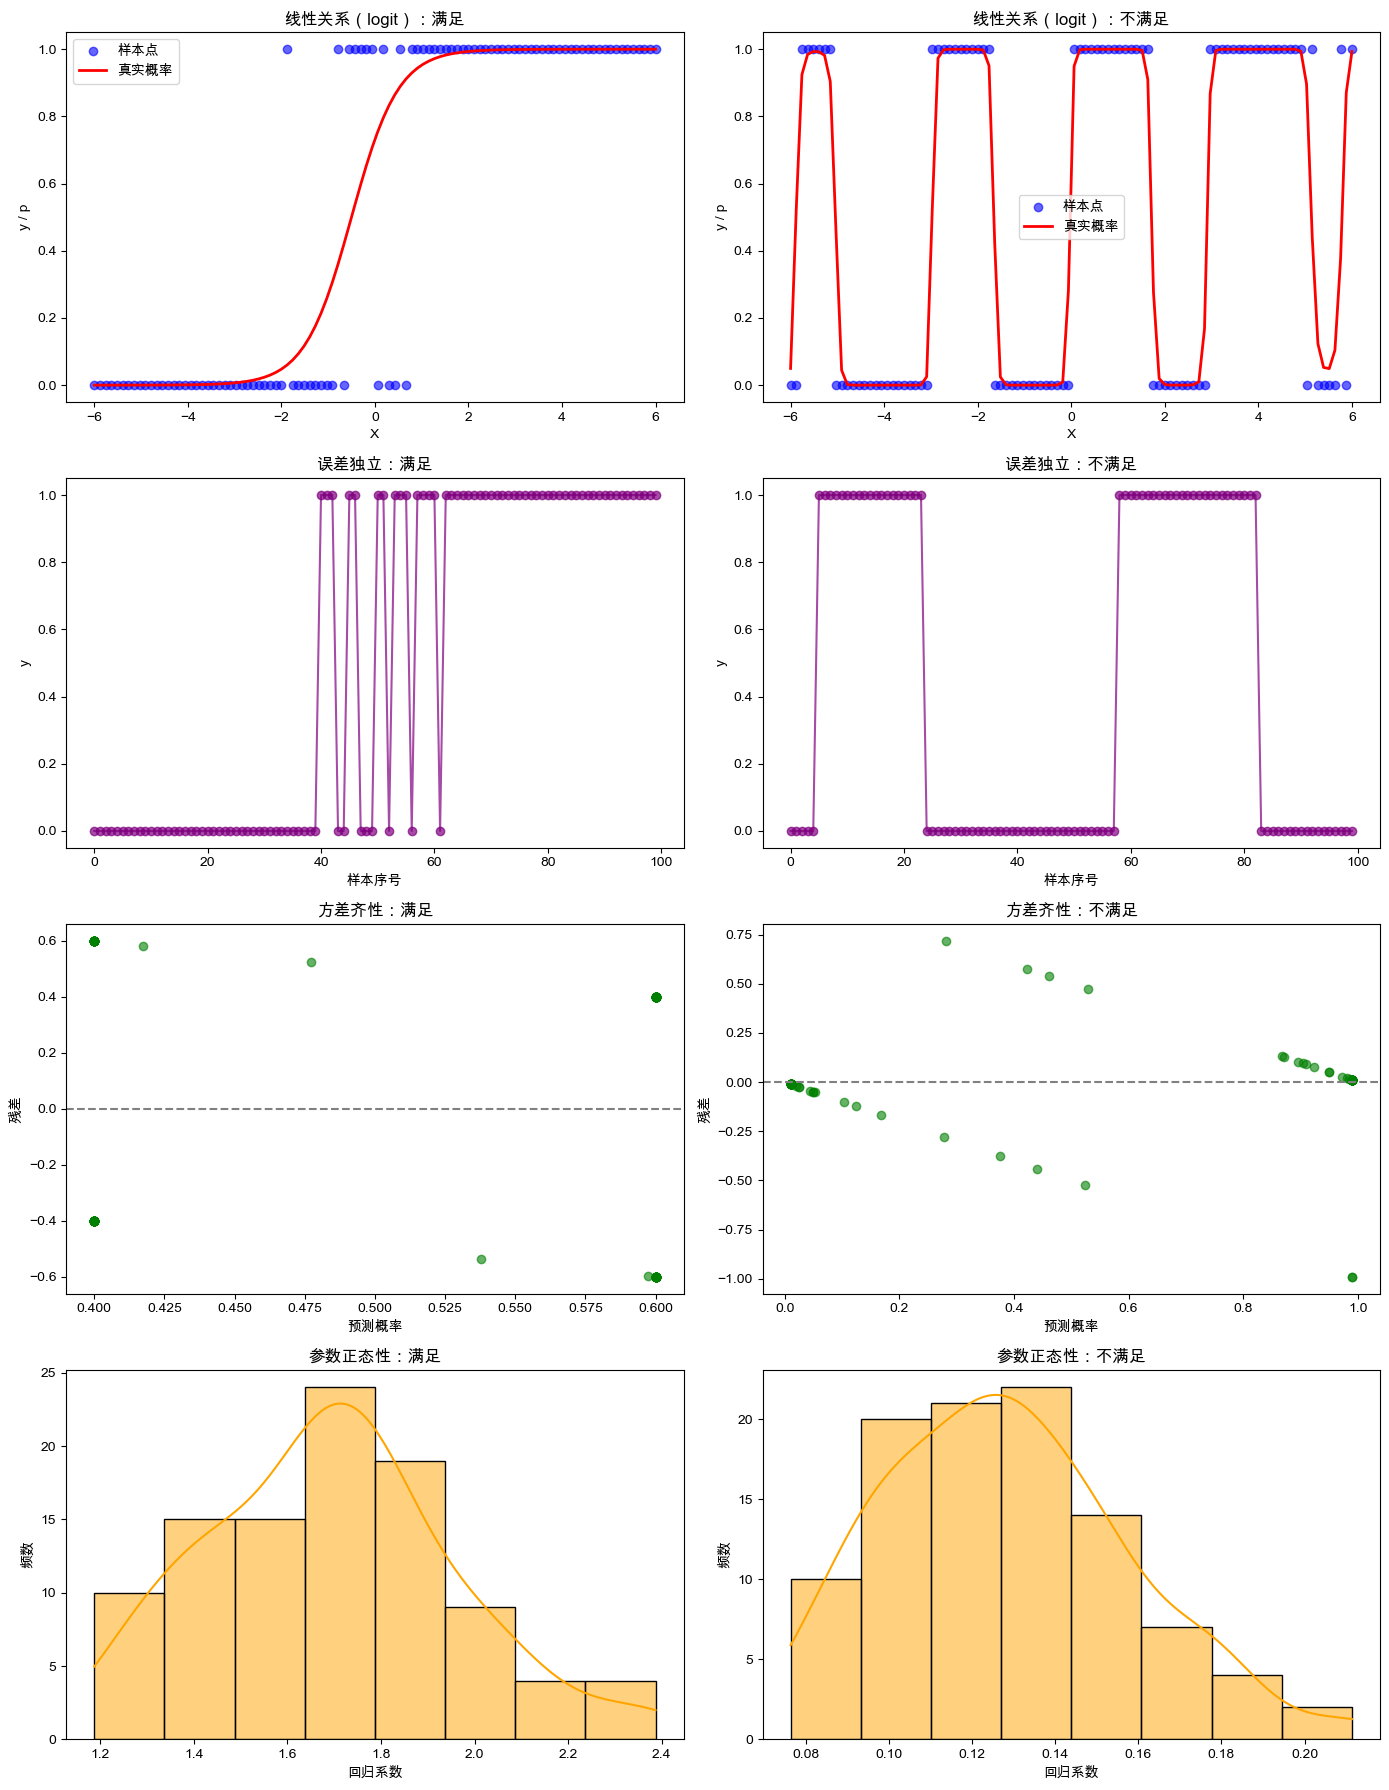

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

plt.rcParams['font.family'] = 'Arial Unicode MS'

np.random.seed(42)
X = np.linspace(-6, 6, 100)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# 1. 线性关系（logit）
y_linear_prob = sigmoid(2 * X + 1)
y_linear = np.random.binomial(1, y_linear_prob)
y_nonlinear_prob = sigmoid(2 * X + 1 + 15 * np.sin(2 * X))  # 波动更剧烈
y_nonlinear = np.random.binomial(1, y_nonlinear_prob)

# 2. 误差独立
y_indep = np.random.binomial(1, sigmoid(2 * X + 1))
y_dep = np.zeros_like(X)
probs = sigmoid(2 * X + 1)
for i in range(len(X)):
    if i == 0:
        y_dep[i] = np.random.binomial(1, probs[i])
    else:
        # 让后一个y依赖前一个y，并加入周期性
        y_dep[i] = np.random.binomial(1, 0.8 * y_dep[i-1] + 0.2 * (0.5 + 0.5 * np.sin(i/8)))

# 3. 方差齐性
y_homo_prob = np.clip(sigmoid(2 * X + 1), 0.4, 0.6)
y_homoscedastic = np.random.binomial(1, y_homo_prob)
y_hetero_prob = np.clip(sigmoid(2 * X + 1 + 15 * np.sin(2 * X)), 0.01, 0.99)
y_heteroscedastic = np.random.binomial(1, y_hetero_prob)

# 4. 正态性（参数分布）
coefs_normal = []
coefs_nonnormal = []
for _ in range(100):
    y_sample = np.random.binomial(1, sigmoid(2 * X + 1))
    model = LogisticRegression().fit(X.reshape(-1, 1), y_sample)
    coefs_normal.append(model.coef_[0][0])
    # 不满足正态性：用极端非线性概率分布
    y_sample2 = np.random.binomial(1, sigmoid(2 * X + 1 + 15 * np.sin(2 * X)))
    model2 = LogisticRegression().fit(X.reshape(-1, 1), y_sample2)
    coefs_nonnormal.append(model2.coef_[0][0])

fig, axes = plt.subplots(4, 2, figsize=(14, 18))
titles = [
    '线性关系（logit）：满足', '线性关系（logit）：不满足',
    '误差独立：满足', '误差独立：不满足',
    '方差齐性：满足', '方差齐性：不满足',
    '参数正态性：满足', '参数正态性：不满足'
]

# 1. 线性关系（logit）
for i, (y, prob, title) in enumerate(zip([y_linear, y_nonlinear], [y_linear_prob, y_nonlinear_prob], titles[:2])):
    axes[0, i].scatter(X, y, color='blue', alpha=0.6, label='样本点')
    axes[0, i].plot(X, prob, color='red', label='真实概率', linewidth=2)
    axes[0, i].set_title(title)
    axes[0, i].set_xlabel('X')
    axes[0, i].set_ylabel('y / p')
    axes[0, i].legend()

# 2. 误差独立
for i, (y, title) in enumerate(zip([y_indep, y_dep], titles[2:4])):
    axes[1, i].plot(y, color='purple', marker='o', linestyle='-', alpha=0.7)
    axes[1, i].set_title(title)
    axes[1, i].set_xlabel('样本序号')
    axes[1, i].set_ylabel('y')

# 3. 方差齐性
for i, (y, prob, title) in enumerate(zip([y_homoscedastic, y_heteroscedastic], [y_homo_prob, y_hetero_prob], titles[4:6])):
    residuals = y - prob
    axes[2, i].scatter(prob, residuals, color='green', alpha=0.6)
    axes[2, i].axhline(0, color='gray', linestyle='--')
    axes[2, i].set_title(title)
    axes[2, i].set_xlabel('预测概率')
    axes[2, i].set_ylabel('残差')

# 4. 正态性（参数分布）
sns.histplot(coefs_normal, kde=True, ax=axes[3, 0], color='orange')
axes[3, 0].set_title(titles[6])
axes[3, 0].set_xlabel('回归系数')
axes[3, 0].set_ylabel('频数')

sns.histplot(coefs_nonnormal, kde=True, ax=axes[3, 1], color='orange')
axes[3, 1].set_title(titles[7])
axes[3, 1].set_xlabel('回归系数')
axes[3, 1].set_ylabel('频数')

plt.tight_layout()
plt.show()

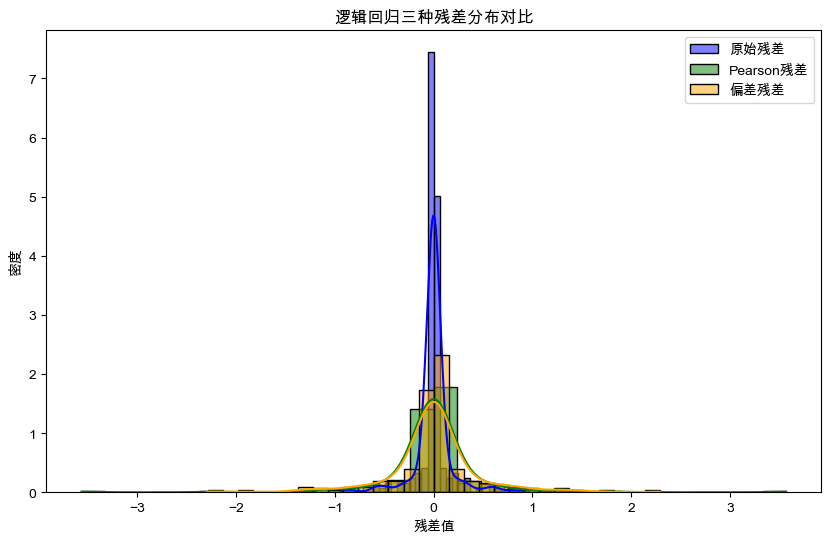

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

np.random.seed(42)
X = np.linspace(-6, 6, 200)
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# 构造数据
y_prob = sigmoid(2 * X + 1)
y = np.random.binomial(1, y_prob)

# 拟合逻辑回归
model = LogisticRegression()
model.fit(X.reshape(-1, 1), y)
y_pred_prob = model.predict_proba(X.reshape(-1, 1))[:, 1]

# 计算三种残差
# 原始残差
res_raw = y - y_pred_prob

# Pearson残差
res_pearson = (y - y_pred_prob) / np.sqrt(y_pred_prob * (1 - y_pred_prob))

# 偏差残差（Deviance residual）
eps = 1e-8  # 防止log(0)
res_deviance = np.sign(y - y_pred_prob) * np.sqrt(
    -2 * (y * np.log(y_pred_prob + eps) + (1 - y) * np.log(1 - y_pred_prob + eps))
)

# 画图
plt.figure(figsize=(10, 6))
sns.histplot(res_raw, color='blue', label='原始残差', kde=True, stat='density', bins=30)
sns.histplot(res_pearson, color='green', label='Pearson残差', kde=True, stat='density', bins=30)
sns.histplot(res_deviance, color='orange', label='偏差残差', kde=True, stat='density', bins=30)
plt.legend()
plt.title('逻辑回归三种残差分布对比')
plt.xlabel('残差值')
plt.ylabel('密度')
plt.show()

## 模型实现

In [ ]:
import numpy as np

class MyLogisticRegression:
    def __init__(self, learning_rate=0.01, n_iters=1000, 
                 fit_intercept=True, method="gd", 
                 alpha=0.0, l1_ratio=0.0):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.fit_intercept = fit_intercept
        self.method = method
        self.alpha = alpha  # 正则化强度
        self.l1_ratio = l1_ratio  # L1占比，0=L2, 1=L1
        self.theta = None

    def _add_intercept(self, X):
        if self.fit_intercept:
            intercept = np.ones((X.shape[0], 1))
            return np.hstack((intercept, X))
        return X

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _loss(self, theta, X, y):
        z = X @ theta
        y_pred = self._sigmoid(z)
        # 逻辑回归负对数似然
        log_loss = -np.mean(y * np.log(y_pred + 1e-8) + (1 - y) * np.log(1 - y_pred + 1e-8))
        # 正则化项，截距theta[0]不正则化
        reg_l1 = self.alpha * self.l1_ratio * np.sum(np.abs(theta[1:]))
        reg_l2 = 0.5 * self.alpha * (1 - self.l1_ratio) * np.sum(theta[1:] ** 2)
        return log_loss + reg_l1 + reg_l2

    def _gradient(self, theta, X, y):
        z = X @ theta
        y_pred = self._sigmoid(z)
        error = y_pred - y
        grad = (1 / len(y)) * (X.T @ error)
        # 正则化梯度，截距theta[0]不正则化
        if self.alpha > 0:
            # L1梯度用次梯度（符号函数），对theta[0]置0
            grad_reg_l1 = self.alpha * self.l1_ratio * np.sign(theta)
            grad_reg_l1[0] = 0
            # L2梯度
            grad_reg_l2 = self.alpha * (1 - self.l1_ratio) * theta
            grad_reg_l2[0] = 0
            grad += grad_reg_l1 + grad_reg_l2
        return grad

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        X = self._add_intercept(X)
        self.theta = np.zeros(X.shape[1])

        if self.method == "newton":
            for _ in range(self.n_iters):
                z = X @ self.theta
                y_pred = self._sigmoid(z)
                W = np.diag(y_pred * (1 - y_pred))
                # 海森矩阵
                if self.alpha > 0 and self.l1_ratio < 1:
                    reg_hessian = self.alpha * (1 - self.l1_ratio) * np.eye(len(self.theta))
                else:
                    reg_hessian = 0
                if isinstance(reg_hessian, int):
                    H = (1 / len(y)) * (X.T @ W @ X)
                else:
                    reg_hessian[0, 0] = 0
                    H = (1 / len(y)) * (X.T @ W @ X) + reg_hessian
                H_inv = np.linalg.pinv(H)
                self.theta -= self.learning_rate * (H_inv @ self._gradient(self.theta, X, y))

        elif self.method == "lbfgs":
            from scipy.optimize import minimize
            def loss(theta):
                return self._loss(theta, X, y)
            def grad(theta):
                return self._gradient(theta, X, y)
            result = minimize(loss, self.theta, jac=grad, method='L-BFGS-B')
            self.theta = result.x

        elif self.method == "gd":
            for _ in range(self.n_iters):
                self.theta -= self.learning_rate * self._gradient(self.theta, X, y)

        else:
            raise ValueError("Unsupported optimization method. Use 'newton', 'lbfgs', or 'gd'.")

    def predict_proba(self, X):
        X = self._add_intercept(np.array(X))
        return self._sigmoid(X @ self.theta)

    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


In [ ]:
# PyTorch 实现逻辑回归

import torch
import torch.nn as nn
import torch.optim as optim

class TorchLogisticRegression(nn.Module):
    def __init__(self, learning_rate=0.01, n_iters=1000,
                 fit_intercept=True, method="gd",
                 alpha=0.0, l1_ratio=0.0, device="cpu"):
        super(TorchLogisticRegression, self).__init__()
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.fit_intercept = fit_intercept
        self.method = method
        self.alpha = alpha  # 正则化强度
        self.l1_ratio = l1_ratio  # L1比例
        self.device = device

        self.theta = None  # 权重参数（包括截距）

    def _add_intercept(self, X):
        if self.fit_intercept:
            intercept = torch.ones((X.shape[0], 1), device=self.device)
            return torch.cat((intercept, X), dim=1)
        return X

    def _sigmoid(self, z):
        return torch.sigmoid(z)

    def _loss(self, y_pred, y, theta):
       pass

    def fit(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device=self.device)
        y = torch.tensor(y, dtype=torch.float32, device=self.device)

        X = self._add_intercept(X)
        n_features = X.shape[1]

        # 初始化参数
        self.theta = nn.Parameter(torch.zeros(n_features, device=self.device))

        if self.method == "gd":  # 梯度下降
            optimizer = optim.SGD([self.theta], lr=self.learning_rate)

            for _ in range(self.n_iters):
                optimizer.zero_grad()
                y_pred = self._sigmoid(X @ self.theta)
                loss = self._loss(y_pred, y, self.theta)
                loss.backward()
                optimizer.step()

        elif self.method == "lbfgs":  # 拟牛顿 L-BFGS
            optimizer = optim.LBFGS([self.theta], lr=self.learning_rate, max_iter=self.n_iters)

            def closure():
                optimizer.zero_grad()
                y_pred = self._sigmoid(X @ self.theta)
                loss = self._loss(y_pred, y, self.theta)
                loss.backward()
                return loss

            optimizer.step(closure)

        elif self.method == "newton":
            # PyTorch 没有直接封装 IRLS (Newton-Raphson)
            # 这里手写实现：Hessian + gradient
            for _ in range(self.n_iters):
                y_pred = self._sigmoid(X @ self.theta)
                W = torch.diag((y_pred * (1 - y_pred)).detach())
                H = (X.T @ W @ X) / len(y)
                grad = torch.autograd.grad(self._loss(y_pred, y, self.theta), self.theta)[0]
                H_inv = torch.linalg.pinv(H)
                with torch.no_grad():
                    self.theta -= self.learning_rate * (H_inv @ grad)

        else:
            raise ValueError("Unsupported method: use 'gd', 'lbfgs', or 'newton'.")

    def predict_proba(self, X):
        X = torch.tensor(X, dtype=torch.float32, device=self.device)
        X = self._add_intercept(X)
        return self._sigmoid(X @ self.theta).detach().cpu().numpy()

    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)

    def score(self, X, y):
        y_pred = self.predict(X)
        return (y_pred == y).mean()


In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# 生成合成数据
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=0, random_state=42)

# 分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 需要测试的配置列表
configs = [
    {"method": "gd", "alpha": 0.0, "l1_ratio": 0.0, "desc": "GD no regularization"},
    {"method": "gd", "alpha": 0.1, "l1_ratio": 0.0, "desc": "GD L2 regularization"},
    {"method": "gd", "alpha": 0.1, "l1_ratio": 1.0, "desc": "GD L1 regularization"},
    {"method": "gd", "alpha": 0.1, "l1_ratio": 0.5, "desc": "GD elastic net"},
    {"method": "newton", "alpha": 0.0, "l1_ratio": 0.0, "desc": "Newton no regularization"},
    {"method": "newton", "alpha": 0.1, "l1_ratio": 0.0, "desc": "Newton L2 regularization"},
    {"method": "newton", "alpha": 0.1, "l1_ratio": 1.0, "desc": "Newton L1 regularization"},
    {"method": "newton", "alpha": 0.1, "l1_ratio": 0.5, "desc": "Newton elastic net"},
    {"method": "lbfgs", "alpha": 0.1, "l1_ratio": 0.5, "desc": "LBFGS elastic net"},
]

for cfg in configs:
    print(f"Testing {cfg['desc']} ...")
    model = MyLogisticRegression(
        learning_rate=0.1,
        n_iters=100,
        method=cfg["method"],
        alpha=cfg["alpha"],
        l1_ratio=cfg["l1_ratio"],
        fit_intercept=True
    )
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    print(f"Accuracy: {acc:.4f}\n")

Testing GD no regularization ...
Accuracy: 0.7600

Testing GD L2 regularization ...
Accuracy: 0.7650

Testing GD L1 regularization ...
Accuracy: 0.7850

Testing GD elastic net ...
Accuracy: 0.7800

Testing Newton no regularization ...
Accuracy: 0.7700

Testing Newton L2 regularization ...
Accuracy: 0.7800

Testing Newton L1 regularization ...
Accuracy: 0.7700

Testing Newton elastic net ...
Accuracy: 0.7900

Testing LBFGS elastic net ...
Accuracy: 0.7800



## 算法实战：广告点击预测
Kaggle项目来源：https://www.kaggle.com/datasets/gabrielsantello/advertisement-click-on-ad/data?select=advertising.csv

In [33]:
import pandas as pd

# 读取数据
data = pd.read_csv('advertising.csv')

# 查看信息
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 78.3+ KB


,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


In [34]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# 1.独热编码处理类别变量
encoder = OneHotEncoder(sparse_output=False)
categorical_cols = ['Ad Topic Line', 'City', 'Country', 'Timestamp']
X_categorical = encoder.fit_transform(data[categorical_cols])
data = data.drop(columns=categorical_cols)
data = pd.concat([data, pd.DataFrame(X_categorical)], axis=1)

 # 查看编码后的数据结构
data.info()

# 2. 标签与特征分离
X = data.drop(columns=['Clicked on Ad'], axis=1)
X.columns = X.columns.astype(str)
y = data['Clicked on Ad']

# 3. 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 查看划分后的形状
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")   
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 3212 entries, Daily Time Spent on Site to 3205
dtypes: float64(3209), int64(3)
memory usage: 24.5 MB
X_train shape: (800, 3211), X_test shape: (200, 3211)
y_train shape: (800,), y_test shape: (200,)


In [47]:
# 定义模型
# model = MyLogisticRegression(
#     learning_rate=0.01,
#     n_iters=20,
#     method="newton",  # 可以尝试 "gd", "lbfgs"
#     alpha=0.1,  # 正则化强度
#     l1_ratio=0.0  # L1占比，0=L2, 1=L1
# )
# # 训练模型
# model.fit(X_train, y_train)
# # 评估模型
# acc = model.score(X_test, y_test)
# print(f"Accuracy: {acc:.4f}\n")
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression

# 使用普通的逻辑回归
model = SklearnLogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)
acc = model.score(X_test, y_test)
print(f"Sklearn Logistic Regression Accuracy: {acc:.4f}\n")

# 使用L1正则化的逻辑回归
model = SklearnLogisticRegression(penalty='l1', solver='liblinear', C=10.0, max_iter=1000)
model.fit(X_train, y_train)
acc = model.score(X_test, y_test)
print(f"Sklearn L1 Logistic Regression Accuracy: {acc:.4f}\n")

# 使用L2正则化的逻辑回归
model = SklearnLogisticRegression(penalty='l2', solver='lbfgs', C=10.0, max_iter=1000)
model.fit(X_train, y_train)
acc = model.score(X_test, y_test)
print(f"Sklearn L2 Logistic Regression Accuracy: {acc:.4f}\n")

# 使用弹性网正则化的逻辑回归
model = SklearnLogisticRegression(penalty='elasticnet', solver='saga', 
                                  l1_ratio=0.5, C=10.0, max_iter=1000)
model.fit(X_train, y_train)
acc = model.score(X_test, y_test)
print(f"Sklearn Elastic Net Logistic Regression Accuracy: {acc:.4f}\n")

# random forest回归
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_acc = rf_model.score(X_test, y_test)
print(f"Random Forest Classifier Accuracy: {rf_acc:.4f}\n")

# xgboost回归
from xgboost import XGBClassifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', 
                          n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_acc = xgb_model.score(X_test, y_test)
print(f"XGBoost Classifier Accuracy: {xgb_acc:.4f}\n")

Sklearn Logistic Regression Accuracy: 0.9500

Sklearn L1 Logistic Regression Accuracy: 0.9500



/opt/homebrew/anaconda3/envs/ml-dl-fullstack-guide/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Sklearn L2 Logistic Regression Accuracy: 0.9300



/opt/homebrew/anaconda3/envs/ml-dl-fullstack-guide/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Sklearn Elastic Net Logistic Regression Accuracy: 0.4450

Random Forest Classifier Accuracy: 0.9400



/opt/homebrew/anaconda3/envs/ml-dl-fullstack-guide/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [05:39:30] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classifier Accuracy: 0.9350

